Calculando...
[5] Feito!
[10] Feito!
[20] Feito!
[50] Feito!


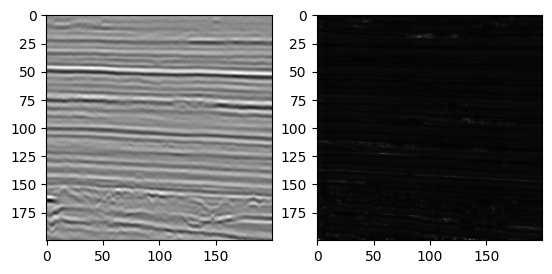

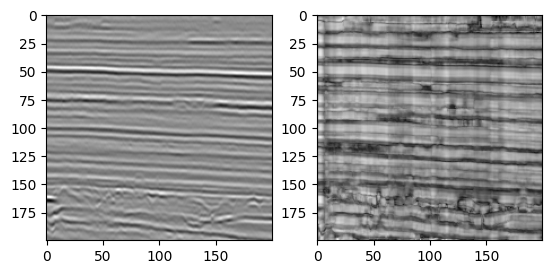

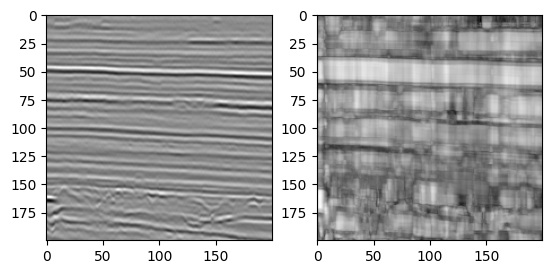

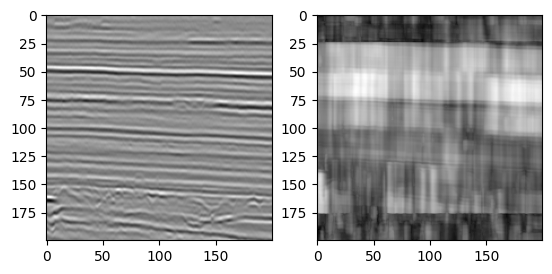

In [5]:
import scipy
import segyio
import numpy as np
from matplotlib import pyplot as plt

   
def bahorich_coherence(data, zwin):
    ni, nj, nk = data.shape
    out = np.zeros_like(data)
    
    # Pad the input to make indexing simpler. We're not concerned about memory usage.
    # We'll handle the boundSaries by "reflecting" the data at the edge.
    padded = np.pad(data, ((0, 1), (0, 1), (zwin//2, zwin//2)), mode='reflect')

    for i, j, k in np.ndindex(ni, nj, nk):
        # Extract the "full" center trace
        center_trace = data[i,j,:]
        
        # Use a "moving window" portion of the adjacent traces
        x_trace = padded[i+1, j, k:k+zwin]
        y_trace = padded[i, j+1, k:k+zwin]

        # Cross correlate. `xcor` & `ycor` will be 1d arrays of length
        # `center_trace.size - x_trace.size + 1`
        xcor = np.correlate(center_trace, x_trace)
        ycor = np.correlate(center_trace, y_trace)
        
        # The result is the maximum normalized cross correlation value
        center_std = center_trace.std()
        px = xcor.max() / (xcor.size * center_std * x_trace.std())
        py = ycor.max() / (ycor.size * center_std * y_trace.std())
        out[i,j,k] = np.sqrt(px * py)

    return out

def plot2(data, bahorich):
    figure = plt.figure()
    ax1 = figure.add_subplot(121)
    ax2 = figure.add_subplot(122)
    sim1 = ax1.imshow(data[0,:,:].T, cmap = 'gray')
    sim2 = ax2.imshow(bahorich[0,:,:].T, cmap = 'gray')

    plt.show()


filename = "./TrainingData_Image.segy"
seismic = segyio.tools.cube(filename)

data = seismic[:200, :200, :200]

print("Calculando...")
bahorich5 = bahorich_coherence(data, 5)
print("[5] Feito!")
bahorich10 = bahorich_coherence(data, 10)
print("[10] Feito!")
bahorich20 = bahorich_coherence(data, 20)
print("[20] Feito!")
bahorich50 = bahorich_coherence(data, 50)
print("[50] Feito!")

plot2(data, bahorich5)
plot2(data, bahorich10)
plot2(data, bahorich20)
plot2(data, bahorich50)

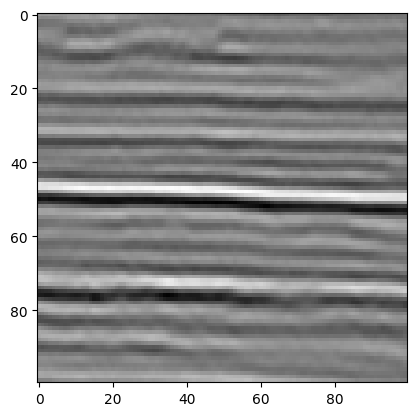

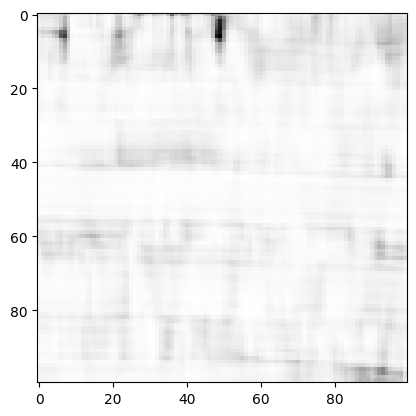

In [2]:
import scipy
import segyio
import numpy as np
from matplotlib import pyplot as plt

def moving_window(data, window, func):
    # `generic_filter` will give the function 1D input. We'll reshape it for convinence
    wrapped = lambda region: func(region.reshape(window))
    
    # Instead of an explicit for loop, we'll use a scipy function to do the same thing
    # The boundaries will be handled by "reflecting" the data, by default
    return scipy.ndimage.generic_filter(data, wrapped, window)

def marfurt_semblance(region):
    # We'll need an ntraces by nsamples array
    region = region.reshape(-1, region.shape[-1])
    ntraces, nsamples = region.shape

    square_of_sums = np.sum(region, axis=0)**2
    sum_of_squares = np.sum(region**2, axis=0)
    return square_of_sums.sum() / sum_of_squares.sum() / ntraces


filename = "./TrainingData_Image.segy"
seismic = segyio.tools.cube(filename)

data = seismic[:100, :100, :100]

plt.imshow(data[0,:,:].T, cmap='gray')
plt.show()

marfurt = moving_window(data, (3, 3, 9), marfurt_semblance)

plt.imshow(marfurt[0,:,:].T, cmap='gray')
plt.show()